# Tutorial 01: Transform Basics

This notebook will demonstrate how to use the forward and inverse operations of the transforms in the *optimaltransport* Python package. We will cover the following transforms:

* Cumulative distribution transform (CDT) - for 1D signals
* Radon-CDT - for 2D signals (e.g. images)

## Import Packages

First, we need to import some useful packages. We will use the numerical Python package *Numpy* for array manipulation, *matplotlib* for plotting figures, and *scikit-image* (*skimage*) to load in some sample data. In order to use the *optimaltransport* package later, we must also add the package code to the current Python path (you can skip this step if the *optimaltransport* package has been installed via the pip package manager).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from skimage import data, img_as_float
from skimage.color import rgb2gray

# Add the optrans package to the Python path
# (change the path below to the location of the optimaltransport directory on your computer)
# Note: this step is not necessary if you have installed optimaltransport through pip.
import sys
sys.path.append('../../optimaltransport')

## Load Sample Data

In order to demonstrate how to use the optimal transport transforms in the *optimaltransport* package, we will first need to load some sample data. The data that we will use in this tutorial are part of the *skimage.data* module. Specifically, we are going to use a photograph from the Hubble Telescope. The photograph shows the Hubble Telescope's farthest ever view of the universe.

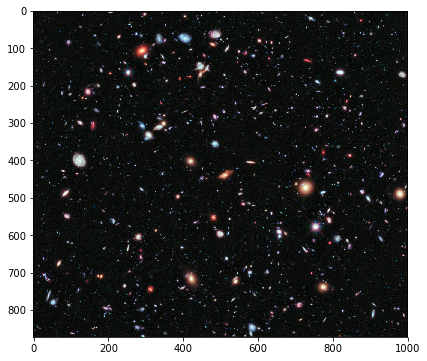

In [79]:
# Load the Hubble eXtreme Deep Field image
img = img_as_float(data.hubble_deep_field())

# Plot the figure
plt.figure(figsize=(12,6))
plt.imshow(img)
plt.show()

The optimal transport methods can only operate on single channel data. The image above has three channels: red, green, and blue. Therefore, going forward, we must convert our image to a single channel (i.e. grayscale). Moreover, since this is quite a photograph (872${\times}$1000px), we are only going to use a small portion of the image in our examples. This will help speed up the computation time for this tutorial. Let's crop two interesting regions for further analysis:

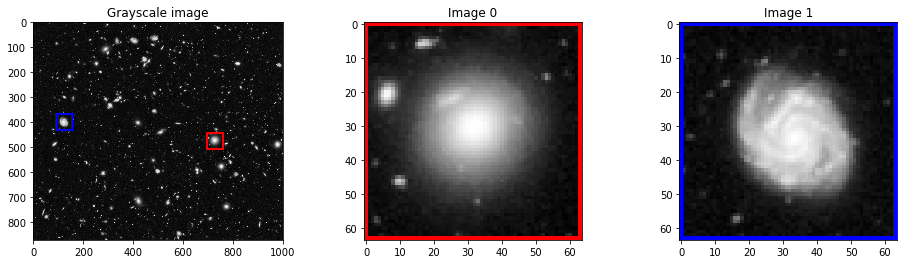

In [81]:
# Convert image to grayscale
img = rgb2gray(img)

# Crop two sub-images from the big image
n = 64
x0, y0 = 695, 443
x1, y1 = 90, 368
img0 = img[y0:y0+n,x0:x0+n]
img1 = img[y1:y1+n,x1:x1+n]

# Plot the images (and rectangles to show their locations in the original photo)
fig, ax = plt.subplots(1,3, figsize=(16,4))
ax[0].imshow(img, cmap='gray')
ax[0].add_patch(patches.Rectangle((x0,y0), n, n, lw=2, ec='r', fc='none'))
ax[0].add_patch(patches.Rectangle((x1,y1), n, n, lw=2, ec='b', fc='none'))
ax[0].set_title('Grayscale image')
ax[1].imshow(img0, cmap='gray')
ax[1].add_patch(patches.Rectangle((0,0), n-1, n-1, lw=4, ec='r', fc='none'))
ax[1].set_title('Image 0')
ax[2].imshow(img1, cmap='gray')
ax[2].add_patch(patches.Rectangle((0,0), n-1, n-1, lw=4, ec='b', fc='none'))
ax[2].set_title('Image 1')
plt.show()

## Cumulative Distribution Transform

Before we get into the code, let's first recap the mathematics of the CDT. Consider two strictly positive probability density functions (PDFs) $I_0$ and $I_1$ defined on $X \subset \mathbb{R}$ and $Y \subset \mathbb{R}$, respectively:

$$
\int_X I_0(\tau) d\tau = \int_Y I_1(\tau) d\tau
$$

If $I_0$ is our "reference" density, we can define the CDT of $I_1$ (denoted $\hat{I}_1$) with respect to $I_0$:

$$
\hat{I}_1(x) = (f(x) - x) \sqrt{I_0(x)}, \quad x \in X
$$

where $f: X \rightarrow Y$ is a mass-preserving mapping that satisfies:

$$
\int_{\inf(X)}^{x} I_0(\tau) d\tau = \int_{\inf(Y)}^{f(x)} I_1(\tau) d\tau, \quad x \in X
$$

The inverse CDT of $\hat{I}_1$ is defined as:

$$
I_1(y) = (f^{-1})'I_0(f^{-1}(y)), \quad y \in Y
$$

where $f^{-1}: Y \rightarrow X$ is the inverse of $f$ (i.e. $f^{-1}(f(x)) = x$), and $I_0$ is the same reference density as before.

The notation used above will be used throughout these tutorials, so it is worth remembering that $I_0$ is our reference signal, $I_1$ is the density that we wish to transform, $f$ is the transport map, and $\hat{I}_1$ is the CDT (or Radon-CDT, or LOT transform) of $I_1$ with respect to the reference.

### Data Pre-Processing

Since the CDT only works for 1D data, our signals will be the central rows from images that we cropped from Hubble eXtreme Deep Field photograph. We can plot the images and corresponding signals below.

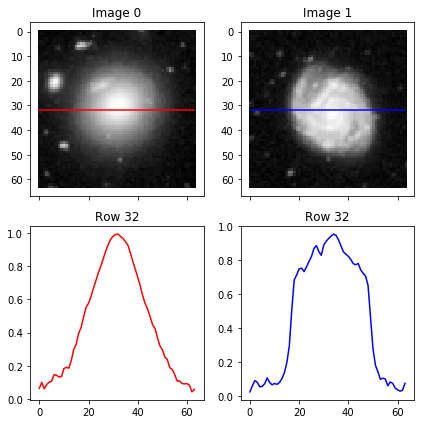

In [82]:
# Select two rows as our signals
row0 = img0[32]
row1 = img1[32]

# Plot the image and signals
_, ax = plt.subplots(2, 2, figsize=(6,6), sharex=True)
ax[0,0].imshow(img0, cmap='gray')
ax[0,0].plot([0,n-1], [32,32], 'r-')
ax[0,0].set_title('Image 0')
ax[0,1].imshow(img1, cmap='gray')
ax[0,1].plot([0,n-1], [32,32], 'b-')
ax[0,1].set_title('Image 1')
ax[1,0].plot(row0, 'r-')
ax[1,0].set_title('Row 32')
ax[1,1].plot(row1, 'b-')
ax[1,1].set_title('Row 32')
plt.tight_layout()
plt.show()

As discussed above, the signals $I_0$ and $I_1$ in the CDF must be non-zero PDFs. Therefore, we have to convert our image rows into PDFS that integrate (or sum) to the same value. Fortunately, the optimaltransport package has a function which can convert an $n$-dimensional signal into a strictly positive PDF: `signal_to_pdf()`.

In [83]:
from optrans.utils import signal_to_pdf

# Convert signals to strictly positive PDFs
sig0 = signal_to_pdf(row0, total=1., epsilon=1e-8, sigma=0.)
sig1 = signal_to_pdf(row1, total=1., epsilon=1e-8, sigma=0.)

The `signal_to_pdf()` function has three optional parameters:

* `total`: this is the desired value of the integral of the PDF (i.e. the sum of the signal). The default is 1, but it could be any positive value. If your signals have a large number of elements, you may wish to increase the total to avoid floating point errors.
* `epsilon`: the offset added to the PDF to make it strictly positive. The default is 1e-8.
* `sigma`: the standard deviation of a Gaussian filter used to smooth the signal before computing the PDF. It is easier to compute the transform of a smooth signal, but beware, too much smoothing could destroy any useful information in the signal! The default value is 0 (i.e. no smoothing).

In this example, we're keeping all three parameters at their default values. Unsurprisingly, the PDFs look similar to the original signals. However, the amplitudes of the peaks are much smaller since the signals now integrate to one. In keeping with the mathematical notation used the optimal transport literature, `sig0` will be our reference density $I_0$ and `sig1` will be the density that we wish to transform $I_1$.

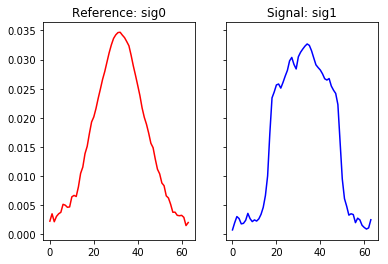

In [84]:
# Plot the PDFs
_, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].plot(sig0, 'r-')
ax[0].set_title('Reference: sig0')
ax[1].plot(sig1, 'b-')
ax[1].set_title('Signal: sig1')
plt.show()

### Computing the CDT

Now that we have two 1D PDFs, we can compute the CDT of our signal $\hat{I}_1$ with respect to the reference as follows:

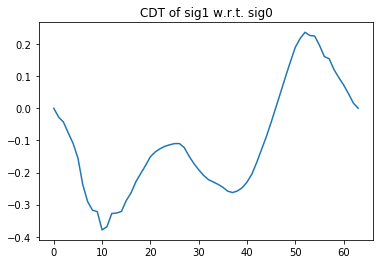

In [85]:
from optrans.continuous import CDT

# Create a CDT object
cdt = CDT()

# Compute the forward transform
sig1_hat = cdt.forward(sig0, sig1)

# Plot the CDT
plt.plot(sig1_hat)
plt.title('CDT of sig1 w.r.t. sig0')
plt.show()

We can also reconstruct `sig1` using the inverse transform:

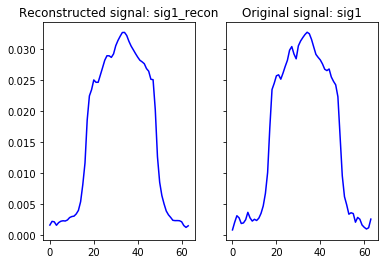

In [86]:
# Reconstruct sig1 using inverse CDT
sig1_recon = cdt.inverse()

# Plot reconstructed signal and the original, for comparison
_, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].plot(sig1_recon, 'b-')
ax[0].set_title('Reconstructed signal: sig1_recon')
ax[1].plot(sig1, 'b-')
ax[1].set_title('Original signal: sig1')
plt.show()

### Improving the Signal Reconstruction

As we can see in the figure above, the reconstructed signal `sig1_recon` does not perfectly match the original signal `sig1`. This is partly due to numerical imprecision, but it is also due to the noisy nature of the signal. If signal reconstructions are important in your application, then there are a couple of techniques that can be used to possibly improve the quality of the inverse CDT.

The first method is to smooth the signal and reference. Similarly to image registration methods, it is easier to compute the transform between two smooth signals. To smooth the PDFs, you can change the `sigma` parameter in the `signal_to_pdf()` function.

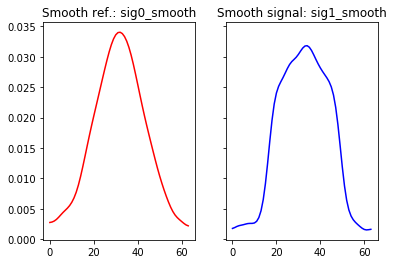

In [87]:
# Convert signals to strictly positive PDFs, and smooth them with a Gaussian filter
sig0_smooth = signal_to_pdf(row0, sigma=2.)
sig1_smooth = signal_to_pdf(row1, sigma=2.)

# Plot the smoothed PDFs
_, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].plot(sig0_smooth, 'r-')
ax[0].set_title('Smooth ref.: sig0_smooth')
ax[1].plot(sig1_smooth, 'b-')
ax[1].set_title('Smooth signal: sig1_smooth')
plt.show()

If we recompute the forward and inverse transforms, we can see how blurring the signals improves the signal reconstruction.

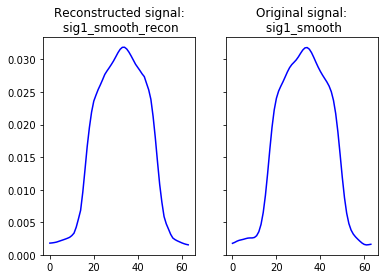

In [88]:
# Compute the forward transform using the smoothed signals
sig1_smooth_hat = cdt.forward(sig0_smooth, sig1_smooth)

# Reconstruct sig1_smooth using inverse CDT
sig1_smooth_recon = cdt.inverse()

# Plot reconstructed signal and the original, for comparison
_, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].plot(sig1_smooth_recon, 'b-')
ax[0].set_title('Reconstructed signal:\n sig1_smooth_recon')
ax[1].plot(sig1_smooth, 'b-')
ax[1].set_title('Original signal:\n sig1_smooth')
plt.show()

Unlike the reconstruction computed using the non-smoothed signals, the peaks in our reconstruction of the smoothed signal `sig1_smooth_recon` more closely match the amplitudes of the peaks in the signal `sig1_smooth`.

Another method to improve the quality of the signal reconstruction without smoothing the signals, is to upsample them. By upsampling the signals, we improve the resolution of the numerical integration that occurs within the `forward()` and `inverse()` functions. To demonstrate this effect, let's upsample our original, non-smoothed PDFs.

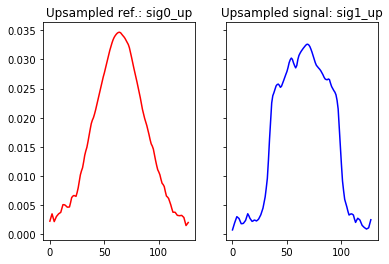

In [89]:
# Domain of the PDFs: x = [0, 1, 2, ...]
x = np.arange(sig0.size)

# Finer resolution domain: x_up = [0, 0.2, 0.4, 0.6, ...]
x_up = np.linspace(0, sig0.size-1, 2*sig0.size)

# Upsample the non-smoothed PDFs
sig0_up = np.interp(x_up, x, sig0)
sig1_up = np.interp(x_up, x, sig1)

# Plot the upsampled PDFs
_, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].plot(sig0_up, 'r-')
ax[0].set_title('Upsampled ref.: sig0_up')
ax[1].plot(sig1_up, 'b-')
ax[1].set_title('Upsampled signal: sig1_up')
plt.show()

Now let's recompute the forward and inverse transforms using the upsampled signals. We will then downsample the results back to the original resolution.

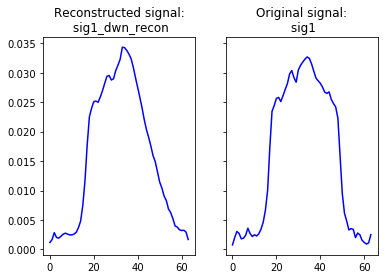

In [90]:
# Compute the forward transform using the upsampled signals
sig1_up_hat = cdt.forward(sig0_up, sig1_up)

# Reconstruct sig1_up using inverse CDT
sig1_up_recon = cdt.inverse()

# Downsample reconstruction to original resolution
sig1_dwn_recon = np.interp(x, x_up, sig1_up_recon)

# Plot reconstructed signal and the original, for comparison
_, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].plot(sig1_dwn_recon, 'b-')
ax[0].set_title('Reconstructed signal:\n sig1_dwn_recon')
ax[1].plot(sig1, 'b-')
ax[1].set_title('Original signal:\n sig1')
plt.show()

Although the reconstruction above does not perfectly match the original signal, there are no large, sudden peaks like the original reconstruction. However, the original, unadulterated signals are fine for the purposes of this tutorial.

### The Transport Map

The transport map $f$ and displacements $u = x - f$ are also available as attributes of the CDT object.

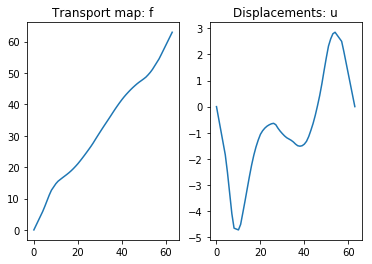

In [91]:
# Recompute the CDT of our original PDFs
sig1_hat = cdt.forward(sig0, sig1)

# Get transport map and displacements
f = cdt.transport_map_
u = cdt.displacements_

# Plot f and u
_, ax = plt.subplots(1,2, sharex=True)
ax[0].plot(f)
ax[0].set_title('Transport map: f')
ax[1].plot(u)
ax[1].set_title('Displacements: u')
plt.show()

In certain applications (e.g. plotting the geodesic between `sig1` and `sig0`), it is useful to apply a user-defined transport map to a signal. This can be achieved using the functions `apply_forward_map()` and `apply_inverse_map()`. For example, we can apply the inverse transport map computed above to reconstruct `sig1`. In this example, this is gives an identical result to using the `inverse()` function. However, the `apply_forward_map()` function computes the following:

$$
I_0(x) = f'(x) I_1(f(x)), \quad x \in X
$$

(i.e. reconstructs the reference $I_0$ from the signal $I_1$.)

We include these functions here for completeness, however, for a more practical example of these functions, we refer the reader to the geodesics tutorial.

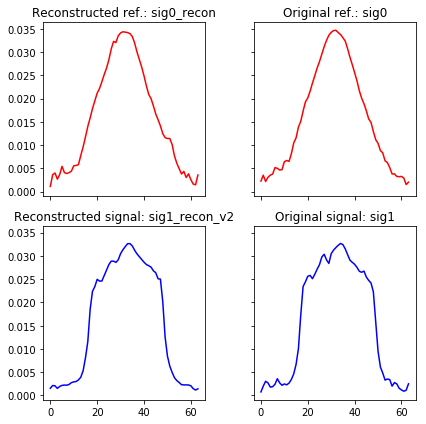

In [94]:
# Apply forward and inverse transport maps
sig0_recon = cdt.apply_forward_map(f, sig1)
sig1_recon_v2 = cdt.apply_inverse_map(f, sig0)

# Plot reconstructed signals and the originals, for comparison
_, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(6,6))
ax[0,0].plot(sig0_recon, 'r-')
ax[0,0].set_title('Reconstructed ref.: sig0_recon')
ax[0,1].plot(sig0, 'r-')
ax[0,1].set_title('Original ref.: sig0')
ax[1,0].plot(sig1_recon_v2, 'b-')
ax[1,0].set_title('Reconstructed signal: sig1_recon_v2')
ax[1,1].plot(sig1, 'b-')
ax[1,1].set_title('Original signal: sig1')
plt.tight_layout()
plt.show()

## Radon-CDT

The Radon-CDT extends the CDT to two dimensions. In short, it works by projecting a 2D PDF into a set of 1D PDFs using the Radon transform, and then computing the 1D CDT of each projection. If $\tilde{I} = \mathscr{R}(I)$ is the Radon transform of a 2D PDF $I$, then the Radon-CDT of $I_1$ (denoted as $\hat{I}_1$, as before) with respect to a reference density $I_0$ is defined as:

$$
\hat{I}_1(t,\theta) = (f(t,\theta) - t)\sqrt{\tilde{I}_0(t,\theta)}, \quad \forall \theta \in [0,\pi]
$$

where $f(t,\theta)$ satisfies:

$$
\int_{-\infty}^{t} \tilde{I}_0(\tau,\theta) d\tau = \int_{-\infty}^{f(t,\theta)} \tilde{I}_1(\tau,\theta) d\tau
$$

Analologously to the CDT, the Radon-CDT has an inverse that can be defined as follows:

$$
I_1 = \mathscr{R}^{-1}(\det(D_g)\tilde{I}_0(g))
$$

where $\mathscr{R}^{-1}(\cdot)$ is the inverse Radon transform, $\det(D_g)$ is the determinant of the Jacobian of $g$, and $g$ is defined $g(t,\theta) = (f^{-1}(t,\theta), \theta)$.

### Data Pre-Processing

Despite the mathematical differences between the Radon-CDT and the CDT, the `RadonCDT` class can be used in an identical manner to the `CDT` class in our earlier examples. The only big difference is that the Radon-CDT works on 2D signals (i.e. images). To demonstrate the `RadonCDT` class and its features, we can use the two sample images $I_0$ and $I_1$ that we extracted from the Hubble eXtreme Deep Field photograph earlier.

It should be reiterated that the Radon-CDT only applies to grayscale images (single channel). Therefore, color images have to be converted to grayscale before computing the Radon-CDT (or you could compute the Radon-CDT for each color channel separately). Fortunately, we already converted our photograph to grayscale.

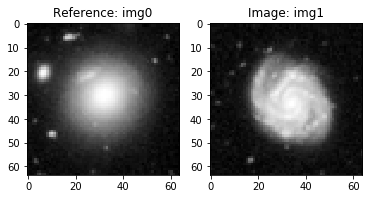

In [99]:
# Re-plot the images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img0, cmap='gray')
ax[0].set_title('Reference: img0')
ax[1].imshow(img1, cmap='gray')
ax[1].set_title('Image: img1')
plt.show()

As before, we need to ensure that the images are strictly positive PDFs, where the sum of all the pixels in `img0` is equal to the sum of the pixels in `img1`. We can achieve this using the `signal_to_pdf()` function from the *optimaltransport* package.

In [96]:
from optrans.utils import signal_to_pdf

# Convert images to PDFs
img0 = signal_to_pdf(img0)
img1 = signal_to_pdf(img1)

### Computing the Radon-CDT

We can compute the forward transform as follows:

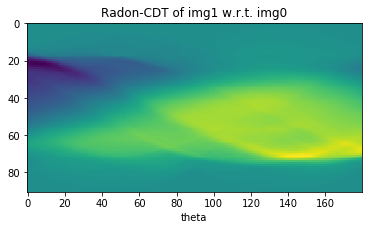

In [97]:
from optrans.continuous import RadonCDT

# Initialize RadonCDT object
radoncdt = RadonCDT()

# Compute forward transform of img1 w.r.t. img0
rcdt = radoncdt.forward(img0, img1)

# Plot the Radon-CDT
plt.imshow(rcdt)
plt.title('Radon-CDT of img1 w.r.t. img0')
plt.xlabel('theta')
plt.show()

We can also reconstruct the image `img1` using the inverse Radon-CDT.

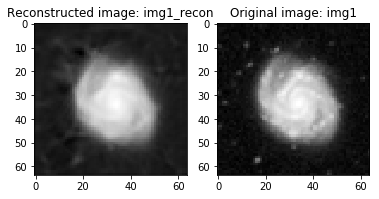

In [98]:
# Reconstruct img1
img1_recon = radoncdt.inverse()

# Plot reconstructed img1 and original, for comparison
fig, ax = plt.subplots(1,2)
ax[0].imshow(img1_recon, cmap='gray')
ax[0].set_title('Reconstructed image: img1_recon')
ax[1].imshow(img1, cmap='gray')
ax[1].set_title('Original image: img1')
plt.show()

The reconstructed image above is not a perfect replica of our original image. This is partly due numerical errors in the Radon transform, as well as the poor quality of the original images. These effects can be negated using similar techniques to those in the CDT reconstruction examples. For example, you could smooth the images using a Gaussian, or upsample the images to improve the resolution of the numerical integration in the `RadonCDT` class. These methods are left as an exercise for the reader, and won't be covered here!

### Radon Projections

As explained earlier, the Radon-CDT takes the Radon transform of the images and computes the 1D CDT for each projection angle. By default, the `RadonCDT` class uses 180 projections (i.e. $\theta = \{0°, 1°, ..., 179°\}$), but you can specify any projection angles when the `RadonCDT` object is initialized. For example, if we wish to use $\theta=\{0°, 2°, 4°, ...\}$:

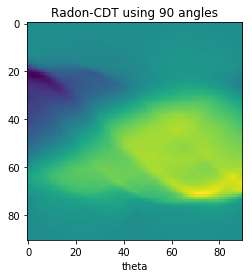

In [100]:
# Initialize RadonCDT object to use 90 projection angles
theta = np.arange(0,179,2)
radoncdt90 = RadonCDT(theta=theta)

# Compute forward transform of img1 w.r.t. img0
rcdt90 = radoncdt90.forward(img0, img1)

# Plot the Radon-CDT
plt.imshow(rcdt90)
plt.title('Radon-CDT using 90 angles')
plt.xlabel('theta')
plt.show()

We can also reconstruct the image `img1` using our Radon-CDT with only 90 projection angles.

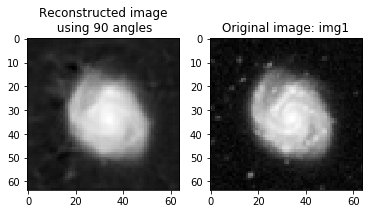

In [101]:
# Reconstruct img1
img1_recon90 = radoncdt90.inverse()

# Plot reconstructed img1 and original, for comparison
fig, ax = plt.subplots(1,2)
ax[0].imshow(img1_recon90, cmap='gray')
ax[0].set_title('Reconstructed image\n using 90 angles')
ax[1].imshow(img1, cmap='gray')
ax[1].set_title('Original image: img1')
plt.show()

### The Transport Map

Analagously to the `CDT` class, the transport map $f$ and displacements $u$ are availabe as attributes of the `RadonCDT` object. The transport map and displacements of our Radon-CDT using 90 projection angles are shown below:

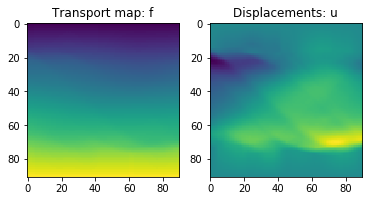

In [102]:
# Transport map f and displacements u
f = radoncdt90.transport_map_
u = radoncdt90.displacements_

# Plot f and u
fig, ax = plt.subplots(1,2)
ax[0].imshow(f)
ax[0].set_title('Transport map: f')
ax[1].imshow(u)
ax[1].set_title('Displacements: u')
plt.show()

It should be noted that due to the nature of the Radon-CDT, the displacements shown above are not the displacements of the pixels in our original images. This is because the Radon-CDT computes the CDT of each projection in the Radon transform of the images.

Since the `CDT` and `RadonCDT` classes are both derived from the same base class, the `RadonCDT` class also has methods for applying forward and inverse transport maps to images. Both the image and reference can be reconstructed using the `apply_inverse_map()` and `apply_forward_map()` functions, respectively. As before, we refer you to the geodesics tutorial for a more practical example of why these functions are useful.

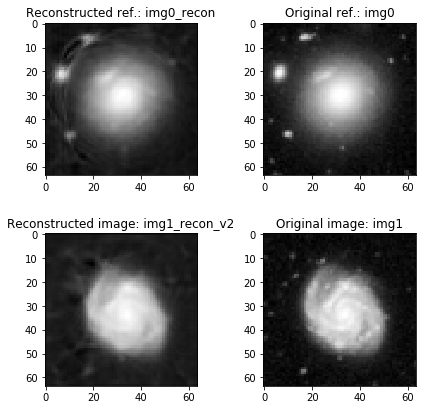

In [107]:
# Apply forward and inverse transport maps
img0_recon = radoncdt90.apply_forward_map(f, img1)
img1_recon_v2 = radoncdt90.apply_inverse_map(f, img0)

# Plot reconstructed images and the originals, for comparison
_, ax = plt.subplots(2, 2, figsize=(6,6))
ax[0,0].imshow(img0_recon, cmap='gray')
ax[0,0].set_title('Reconstructed ref.: img0_recon')
ax[0,1].imshow(img0, cmap='gray')
ax[0,1].set_title('Original ref.: img0')
ax[1,0].imshow(img1_recon_v2, cmap='gray')
ax[1,0].set_title('Reconstructed image: img1_recon_v2')
ax[1,1].imshow(img1, cmap='gray')
ax[1,1].set_title('Original image: img1')
plt.tight_layout()
plt.show()